# 6 - Attention is All you need

在这个笔记本中，我们将实现《Attention is All You Need》论文中Transformer模型的一个（稍微修改的版本）。本笔记本中的所有图像都将取自Transformer论文。有关Transformer的更多信息，请参见这三篇文章：[1](https://www.mihaileric.com/posts/transformers-attention-in-disguise/)、[2](https://jalammar.github.io/illustrated-transformer/)、[3](http://nlp.seas.harvard.edu/2018/04/03/attention.html)。

![](assets/transformer1.png)

## 介绍

与卷积序列到序列模型类似，Transformer不使用任何循环。它也不使用任何卷积层。相反，该模型完全由线性层、注意机制和标准化层组成。

截至2024年1月，Transformer是自然语言处理中的主导架构，并且被用于许多任务以及在可预见的未来内可能仍然是主导架构。

最流行的Transformer变体之一是BERT（**B**idirectional **E**ncoder **R**epresentations from **T**ransformers），BERT的预训练版本通常用于替换NLP模型中的嵌入层 (甚至是更多部分)。

在处理预训练transformer时，常用的库是[Transformers](https://huggingface.co/transformers/)库，有关所有预训练模型的列表，请参见[这里](https://huggingface.co/transformers/pretrained_models.html)。

在本笔记本中的实现与论文中的有所不同：
- 我们使用了一个学习到的位置编码，而不是静态的位置编码。
- 我们使用具有静态学习率的标准Adam优化器，而不是具有热启动和冷却步骤的优化器。
- 我们没有使用标签平滑。

我们进行所有这些更改是因为它们与BERT的设置紧密相似，并且大多数Transformer变体使用类似的设置。


## 准备数据

首先，让我们导入所有必需的模块并设置用于可重复性的随机种子。

In [1]:
import mindspore as ms
import mindspore.context as context
import mindspore.nn as nn
import mindspore.ops as ops
from functools import partial

import random
import time
import numpy as np
import spacy
import datasets
from tqdm.notebook import tqdm
import evaluate as evaluate_hf
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

In [2]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
ms.set_seed(seed)

In [3]:
dataset = datasets.load_dataset("bentrevett/multi30k")
train_data, valid_data, test_data = dataset["train"], dataset["validation"], dataset["test"]
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")
def tokenize_example(
    example,
    en_nlp,
    de_nlp,
    max_length,
    lower,
    sos_token,
    eos_token
):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}


max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp, 
    "de_nlp": de_nlp, 
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}


train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Found cached dataset json (/root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-39e2a81dd5826464.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-340eed13fdfe768e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-05a87c7dda3754fe.arrow


In [4]:
import collections
class Vocab:
    """一个词汇表的实现"""
    def __init__(self, tokens:list, min_freq=0, reserved_tokens:list=None) -> None:
        self.default_index = None
        if tokens is not None:
            # 当第一个条件满足时，就不会跳到第二个判断，避免了空列表报错的情况。
            if len(tokens)!=0 and isinstance(tokens[0], list):
                tokens = [i for line in tokens for i in line]
        else:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter=collections.Counter(tokens)
        # 按出现词频从高到低排序
        self._token_freqs = sorted(counter.items(), key=lambda x:x[1], reverse=True)
        # 通过列表,利用序号访问词元。
        self.idx_to_token = [] + reserved_tokens # 未知词元<unk>的索引为0, 保留词元排在最前
        self.token_to_idx = {
            i: k
            for k, i in enumerate(self.idx_to_token) 
        }
        
        for token, freq in self._token_freqs:
            if freq < min_freq:  # 过滤掉出现频率低于要求的词
                break
            if token not in self.token_to_idx:  
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
        
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, input_tokens):
        """输入单字串或序列, 将其全部转化为序号编码"""
        if isinstance(input_tokens, str):
            out =  self.token_to_idx.get(input_tokens, self.default_index)
            if out is None:
                raise Exception('Please call "set_default_index" before getting unknown index')
            return out
        return [self.__getitem__(token) for token in input_tokens]
    
    def __repr__(self) -> str:
        show_items = 5 if len(self) > 5 else len(self)
        out = f"<Vocab with {len(self)} tokens: "
        for i in range(show_items):
            out += f'"{self.idx_to_token[i]}", '
        out += "...>"
        return out

    def __contains__(self, token:str) -> bool:
        return token in self.idx_to_token

    def to_tokens(self, input_keys):
        """输入单s索引或序列, 将其全部转化为词元"""
        if isinstance(input_keys, int):
            return self.idx_to_token[input_keys] if input_keys < len(self) else self.idx_to_token[0]
        elif isinstance(input_keys, (list, tuple)):
            return [self.to_tokens(keys) for keys in input_keys]
        else:
            return self.idx_to_token[0]
    
    def get_itos(self):
        return self.idx_to_token
    
    def get_stoi(self):
        return self.token_to_idx
    
    def set_default_index(self, idx):
        if isinstance(idx, int):
            self.default_index = idx
        else:
            raise Exception(f"Only type int allowed, got {type(idx)}")

    def lookup_indices(self, input_tokens):
        return self.__getitem__(input_tokens)
    
    def lookup_tokens(self, idx):
        return self.to_tokens(idx)

In [5]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

def build_vocab_from_iterator(tokens, min_freq, specials):
    return Vocab(tokens, min_freq, specials)

en_vocab = build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

de_vocab = build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=special_tokens,  
)

assert en_vocab[unk_token] == de_vocab[unk_token]
assert en_vocab[pad_token] == de_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)

def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

fn_kwargs = {
"en_vocab": en_vocab, 
"de_vocab": de_vocab
}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-6689c04abfdb721f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-acab783df695b18d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-e1088b8589007c26.arrow


In [6]:
data_type = "numpy"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True,
)

In [7]:
def pad_sequence(sequences:list, padding_value:int):
    '''将序列填充到等长并返回mindspore张量'''
    # Find the length of the longest sequence in the batch
    max_length = max(len(seq) for seq in sequences)
    padded_sequences:ms.Tensor = ops.full((len(sequences), max_length), padding_value, dtype=ms.int64)
    # Copy the sequences into the padded array
    for i, seq in enumerate(sequences):
        padded_sequences[i, :len(seq)] = ms.tensor(seq).astype(np.int64)
    # 换轴，保证输出为时序优先
    padded_sequences = padded_sequences.swapaxes(0, 1)
    return padded_sequences  

def get_collate_fn(pad_index):
    
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }
        return batch
    
    return collate_fn

In [8]:
class DataLoader:
    def __init__(self, source, batch_size, shuffle=False, per_batch_map=None):
        self.source = source
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.per_batch_map = per_batch_map
        self.indices = np.arange(len(source))
        self.current_index = 0

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index >= len(self.source):
            self.current_index = 0
            raise StopIteration

        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        batch_data = [self.source[int(i)] for i in batch_indices]

        if self.per_batch_map:
            batch_data = self.per_batch_map(batch_data)

        self.current_index += self.batch_size
        return batch_data
    
    def __len__(self):
        return len(self.source) // self.batch_size


def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    dataloader = DataLoader(dataset, batch_size, shuffle=shuffle, per_batch_map=collate_fn)
    
    return dataloader

In [9]:
batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

# 构建模型

接下来，我们将构建模型。与前面的笔记本一样，它由一个*编码器*和一个*解码器*组成，其中编码器将输入/源语句（德语）*编码*成*上下文向量*，解码器然后*解码*这个上下文向量以输出我们的输出/目标语句（英语）。

### 位置逐元素前馈层

编码器层内的一个主要模块是 *位置逐元素前馈层*。与多头注意层相比，这相对简单。输入从 `hid_dim` 转换为 `pf_dim`，其中 `pf_dim` 通常比 `hid_dim` 大得多。原始的 Transformer 使用了 `hid_dim` 为 512 和 `pf_dim` 为 2048。在将其转换回 `hid_dim` 表示之前，应用了 ReLU 激活函数和 dropout。

为什么要使用这个？不幸的是，在论文中没有解释。

BERT 使用 [GELU](https://arxiv.org/abs/1606.08415) 激活函数，可以通过将 `ops.relu` 替换为 `ops.gelu` 来使用。为什么使用 GELU？同样，没有解释。


In [39]:
class PositionwiseFeedforwardLayer(nn.Cell):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Dense(hid_dim, pf_dim)
        self.fc_2 = nn.Dense(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def construct(self, x):
        #x = [batch size, seq len, hid dim]
        x = self.dropout(ops.relu(self.fc_1(x)))
        #x = [batch size, seq len, pf dim]
        x = self.fc_2(x)
        #x = [batch size, seq len, hid dim]
        
        return x

### 多头注意力层

Transformer 论文引入的一个关键而新颖的概念是 *多头注意力层*。

![](assets/transformer-attention.png)

注意力可以被视为 *查询*、*键* 和 *值* 的过程 - 其中查询与键一起用于获取注意力向量（通常是 *softmax* 操作的输出，并且具有在 0 和 1 之间的所有值，这些值的总和为 1），然后使用它来获取值的加权和。

Transformer 使用 *缩放点积注意力*，其中通过对它们进行点积，然后应用 softmax 操作并通过 $d_k$ 进行缩放，最后乘以值，将查询和键组合在一起。$d_k$ 是 *头维度*，`head_dim`，我们将很快进一步解释。

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

这类似于标准的 *点积注意力*，但是通过 $d_k$ 进行了缩放，论文中指出这是为了防止点积结果变得很大，导致梯度变得过小。

然而，缩放的点积注意力不仅仅应用于查询、键和值。我们不仅仅执行单一的注意力应用，而是将查询、键和值的 `hid_dim` 分成 $h$ 个 *头*，并且在所有头上并行计算缩放的点积注意力。这意味着我们不是在每次注意力应用中关注一个概念，而是关注 $h$ 个概念。然后，我们将头重新组合成它们的 `hid_dim` 形状，因此每个 `hid_dim` 可能关注 $h$ 个不同的概念。

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ 是应用在多头注意力层末端的线性层，`fc`。$W^Q, W^K, W^V$ 是线性层 `fc_q`、`fc_k` 和 `fc_v`。

遍历模块时，首先我们使用线性层 `fc_q`、`fc_k` 和 `fc_v` 计算 $QW^Q$、$KW^K$ 和 $VW^V$，得到 `Q`、`K` 和 `V`。接下来，我们使用 `.view` 将查询、键和值的 `hid_dim` 分成 `n_heads`，并正确地对它们进行排列，以便可以相互相乘。然后，通过将 `Q` 和 `K` 相乘并通过头维度的平方根进行缩放来计算 *能量*（未经标准化的注意力）。然后我们对能量进行屏蔽，以便我们不会关注任何我们不应该关注的序列元素，然后应用 softmax 和 dropout。然后我们将注意力应用于值头 `V`，然后将 `n_heads` 组合在一起。最后，我们将其乘以 $W^O$，表示为 `fc_o`。

请注意，在我们的实现中，键和值的长度始终相同，因此在对 softmax 的输出 `attention` 与 `V` 进行矩阵乘法时，我们将始终具有矩阵乘法的有效维度大小。此乘法使用 `matmul` 进行，当两个张量的维数均 >2 时，将在每个张量的最后两个维度上执行批次矩阵乘法。这将是一个 $[query\ len, key\ len] \times [value\ len, head\ dim]$ 批次矩阵乘法，其中提供 $[batch\ size, n\ heads, query\ len, head\ dim]$ 结果。

一开始看起来有些奇怪的是，dropout 直接应用于注意力。这意味着我们的注意力向量很可能不会总和为 1，我们可能会全神贯注于一个token，但是由于 dropout 将注意力在该token上的注意力设置为 0，因此全神贯注于一个token的可能性很大。论文中从未解释过这一点，也没有提到过，但它被 [官方实现](https://github.com/tensorflow/tensor2tensor/) 以及之后的每个 Transformer 实现所使用，[包括 BERT](https://github.com/google-research/bert/)。


In [40]:
class MultiHeadAttentionLayer(nn.Cell):
    def __init__(self, hid_dim, n_heads, dropout):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Dense(hid_dim, hid_dim)
        self.fc_k = nn.Dense(hid_dim, hid_dim)
        self.fc_v = nn.Dense(hid_dim, hid_dim)
        
        self.fc_o = nn.Dense(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
        self.scale = ops.sqrt(ms.Tensor([self.head_dim]).astype(ms.float32))
        
    def construct(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = ops.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = ops.softmax(energy, axis = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = ops.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3)
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### 编码器层

编码器层包含了编码器的所有关键部分。我们首先将源句子和其掩码传递到 *多头注意力层*，然后对其执行 dropout，应用残差连接，并通过 [层归一化](https://arxiv.org/abs/1607.06450) 层。然后，我们将其传递到 *位置前馈* 层，再次应用 dropout，残差连接，然后进行层归一化，以获得此层的输出，该输出输入到下一层。各层之间的参数不共享。

多头注意力层由编码器层用于关注源句子，即它在自身上计算和应用注意力，而不是在另一个序列上，因此我们称其为 *自注意力*。

[这篇文章](https://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/) 对层归一化进行了更详细的解释，但要点是它对特征的值进行归一化，即在隐藏维度上进行，因此每个特征的均值为 0，标准差为 1。这使得具有更多层的神经网络，如 Transformer，更容易训练。


In [41]:
class EncoderLayer(nn.Cell):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 ):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm((hid_dim,))
        self.ff_layer_norm = nn.LayerNorm((hid_dim,))
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(p=dropout)
        
    def construct(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src



### 编码器

与ConvSeq2Seq模型类似，Transformer的编码器并不试图将整个源语句$X=(x_1, ..., x_n)$压缩成一个单一的上下文向量$z$。相反，它生成一个上下文向量序列$Z=(z_1, ..., z_n)$。因此，如果我们的输入序列有5个标记，我们将得到$Z=(z_1, z_2, z_3, z_4, z_5)$。为什么我们称这个为上下文向量序列而不是隐藏状态序列呢？RNN中时间$t$的隐藏状态只看到标记$x_t$和所有之前的标记。然而，这里的每个上下文向量都看到了输入序列中所有位置的所有标记。

![](assets/transformer-encoder.png)

首先，标记通过一个标准的嵌入层。接下来，由于该模型没有循环，它对序列中标记的顺序一无所知。我们通过使用第二个嵌入层来解决这个问题，称为*位置嵌入层*。这是一个标准的嵌入层，其中输入不是标记本身，而是标记在序列中的位置，从第一个标记开始，即`<sos>`（序列开始）标记，在位置0。位置嵌入具有100的“词汇表”大小，这意味着我们的模型可以接受长达100个标记的句子。如果要处理更长的句子，可以增加这个值。

然后，token和位置嵌入进行逐元素求和，得到一个包含关于标记及其在序列中的位置信息的向量。然而，在它们相加之前，token嵌入会乘以一个缩放因子，即$\sqrt{d_{model}}$，其中$d_{model}$是隐藏维度大小，`hid_dim`。据说这样可以减小嵌入的方差，而没有这个缩放因子，该模型很难可靠地训练。然后对组合嵌入应用了丢弃。

然后，将组合嵌入通过$N$个*编码器层*以获得$Z$，然后输出，可以由解码器使用。

源掩码`src_mask`的形状与源语句相同，但是在源语句中的标记不是`<pad>`标记时，它的值为1，而在是`<pad>`标记时为0。在编码器层中用于屏蔽多头注意机制，该机制用于计算并应用于源语句的注意力，以便模型不关注`<pad>`标记，这些标记不包含有用的信息。


In [42]:
class Encoder(nn.Cell):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 max_length = 100):
        super().__init__()

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.CellList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  ) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(p=dropout)
        
        self.scale = ops.sqrt(ms.Tensor([hid_dim]).astype(ms.float32))
        
    def construct(self, src, src_mask, pos):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        # pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

### 解码器层

如前所述，解码器层与编码器层相似，只是现在它有两个多头注意力层，`self_attention` 和 `encoder_attention`。

第一个执行自注意力，与编码器一样，使用迄今为止的解码器表示作为查询、键和值。然后是 dropout、残差连接和层归一化。这个 `self_attention` 层使用目标序列掩码 `trg_mask`，以防止解码器通过关注当前处理的token之前的token来“作弊”，因为它同时处理目标句子中的所有token。

第二个是我们实际上如何将编码的源句子 `enc_src` 输入到我们的解码器中。在这个多头注意力层中，查询是解码器表示，而键和值是编码器表示。在这里，源掩码 `src_mask` 用于防止多头注意力层关注源句子中的 `<pad>` token。然后是 dropout、残差连接和层归一化层。

最后，我们将其通过位置前馈层，再经过一系列的 dropout、残差连接和层归一化。


In [43]:
class DecoderLayer(nn.Cell):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 ):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm((hid_dim,))
        self.enc_attn_layer_norm = nn.LayerNorm((hid_dim,))
        self.ff_layer_norm = nn.LayerNorm((hid_dim,))
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(p=dropout)
        
    def construct(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### 解码器

解码器的目标是接受源句子的编码表示 $Z$，并将其转换为目标句子中的预测token $\hat{Y}$。然后，我们将 $\hat{Y}$ 与目标句子中的实际token $Y$ 进行比较，计算我们的损失，该损失将用于计算参数的梯度，然后使用优化器更新权重以改善我们的预测。

![transformer-decoder](assets/transformer-decoder.png)

解码器与编码器相似，但现在它有两个多头注意力层。一个是对目标序列的 *掩码多头注意力层*，另一个是使用解码器表示作为查询以及编码器表示作为键和值的多头注意力层。

解码器使用位置嵌入，并通过按元素求和的方式与缩放嵌入的目标token相结合，然后进行 dropout。再次提到，我们的位置编码具有 100 的 "词汇量"，这意味着它们可以接受长达 100 个token的序列。如果需要，这个长度可以增加。

组合后的嵌入然后通过 $N$ 个解码器层传递，同时还有编码的源 `enc_src`、源掩码和目标掩码。请注意，编码器的层数不必等于解码器的层数，即使它们都用 $N$ 表示。

第 $N$ 层后的解码器表示然后通过线性层 `fc_out`。在 PyTorch 中，softmax 操作包含在我们的损失函数中，因此我们在这里不需要明确使用 softmax 层。

除了使用源掩码（与我们在编码器中使用的方式相同，以防止模型关注 `<pad>` token），我们还使用目标掩码。这将在封装编码器和解码器的 `Seq2Seq` 模型中进一步解释，但其要点是它执行与卷积序列到序列模型中解码器填充类似的操作。由于我们一次并行处理所有目标token，我们需要一种方法来阻止解码器通过简单地“查看”目标序列中的下一个token并将其输出来“作弊”。

我们的解码器层还输出了归一化的注意力值，因此我们稍后可以绘制它们，了解我们的模型实际上关注的是什么。


In [44]:
class Decoder(nn.Cell):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 max_length = 100):
        super().__init__()
    
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.CellList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  )
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Dense(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
        self.scale = ops.sqrt(ms.Tensor([hid_dim]).astype(ms.float32))
        
    def construct(self, trg, enc_src, trg_mask, src_mask, pos):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        # pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Seq2Seq

最后，我们有 `Seq2Seq` 模块，它封装了编码器和解码器，并处理了掩码的创建。

源掩码是通过检查源序列是否不等于 `<pad>` token而创建的。其中token不是 `<pad>` token时，它为 1；否则为 0。然后对其进行 unsqueeze 操作，以便在将掩码应用于 `energy` 时可以正确广播。`energy` 的形状为 **_[batch size, n heads, seq len, seq len]_**。

目标掩码稍微复杂一些。首先，我们为 `<pad>` token创建一个掩码，就像我们对源掩码所做的一样。接下来，我们使用 `torch.tril` 创建一个“后续”掩码 `trg_sub_mask`。这将创建一个对角矩阵，其中对角线以上的元素将为零，对角线以下的元素将设置为输入张量的值。在这种情况下，输入张量将是一个用一填充的张量。因此，我们的 `trg_sub_mask` 将类似于这样（对于包含 5 个token的目标）：

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

这显示了每个目标token（行）被允许查看的内容（列）。第一个目标token的掩码为 **_[1, 0, 0, 0, 0]_**，这意味着它只能查看第一个目标token。第二个目标token的掩码为 **_[1, 1, 0, 0, 0]_**，这意味着它可以查看第一个和第二个目标token。

然后，将“后续”掩码与填充掩码进行逻辑与操作，这将两个掩码组合在一起，确保后续token和填充token都不能被关注到。例如，如果最后两个token是 `<pad>` token，则掩码将如下所示：

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

创建掩码后，它们与编码器和解码器以及源和目标句子一起用于获取我们的预测目标句子 `output`，以及解码器对源序列的注意力。


In [45]:
class Seq2Seq(nn.Cell):
    def __init__(self, 
                 encoder:Encoder, 
                 decoder:Decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 ):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx     
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = ops.tril(ops.ones((trg_len, trg_len),)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def construct(self, src, trg, src_mask, trg_mask, enc_pos, dec_pos):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        # src_mask = self.make_src_mask(src)
        # trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask, enc_pos)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask, dec_pos)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## 训练 Seq2Seq 模型

现在我们可以定义我们的编码器和解码器了。这个模型比今天研究中使用的 Transformer 要小得多，但可以在单个 GPU 上快速运行。


In [46]:
INPUT_DIM = len(de_vocab)
OUTPUT_DIM = len(en_vocab)

HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              )

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              )

然后，使用它们来定义我们的整个序列到序列封装模型。

In [47]:
SRC_PAD_IDX = de_vocab.get_stoi()[pad_token]
TRG_PAD_IDX = en_vocab.get_stoi()[pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX)

我们可以检查参数的数量，注意到它明显少于卷积序列到序列模型的 3700 万个参数。


In [48]:
def count_parameters(model):
    return sum(p.numel() for p in model.get_parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


论文没有提到使用了哪种权重初始化方案，然而，Xavier 均匀分布似乎在 Transformer 模型中很常见，因此我们在这里使用它。


In [49]:
from mindspore import Parameter
from mindspore.common.initializer import initializer, XavierUniform

def init_weights(m:nn.Cell):
    for name, param in m.parameters_and_names():
        if "weight" in name:
            param.set_data(Parameter(initializer(XavierUniform(), param.shape, ms.float32)))

model.apply(init_weights)

Seq2Seq<
  (encoder): Encoder<
    (tok_embedding): Embedding<vocab_size=7853, embedding_size=256, use_one_hot=False, embedding_table=Parameter (name=encoder.tok_embedding.embedding_table, shape=(7853, 256), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
    (pos_embedding): Embedding<vocab_size=100, embedding_size=256, use_one_hot=False, embedding_table=Parameter (name=encoder.pos_embedding.embedding_table, shape=(100, 256), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
    (layers): CellList<
      (0): EncoderLayer<
        (self_attn_layer_norm): LayerNorm<normalized_shape=(256,), begin_norm_axis=-1, begin_params_axis=-1, gammaParameter (name=encoder.layers.0.self_attn_layer_norm.gamma, shape=(256,), dtype=Float32, requires_grad=True), beta=Parameter (name=encoder.layers.0.self_attn_layer_norm.beta, shape=(256,), dtype=Float32, requires_grad=True)>
        (ff_layer_norm): LayerNorm<normalized_shape=(256,), begin_norm_axis=-1, begin_para

原始 Transformer 论文中使用的优化器是具有“预热”和“冷却”周期的 Adam 学习率。BERT 和其他 Transformer 模型使用具有固定学习率的 Adam，因此我们将实现这一点。查看[此链接](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer)以获取有关原始 Transformer 学习率计划的更多详细信息。

请注意，学习率需要低于 Adam 默认值，否则学习会不稳定。


In [50]:
LEARNING_RATE = 0.0005

optimizer = nn.Adam(model.trainable_params(), learning_rate=LEARNING_RATE)

接下来，我们定义我们的损失函数，确保忽略计算 `<pad>` token上的损失。


In [51]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

然后，我们定义训练循环。这与前面教程中使用的循环完全相同。

由于我们希望模型预测 `<eos>` token但不将其作为输入传递到我们的模型中，因此我们只需将序列末尾的 `<eos>` token切掉。因此：

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

这里的 $x_i$ 表示实际的目标序列元素。然后，我们将其馈送到模型中，以获得一个预测序列，希望能够预测 `<eos>` token：

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

这里的 $y_i$ 表示预测的目标序列元素。然后，我们使用原始的 `trg` 张量计算损失，其中 `<sos>` token被切掉，仅保留 `<eos>` token：

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

然后，我们计算损失并按标准更新参数。


In [58]:
def forward_fn(src, trg, src_mask, trg_mask, enc_pos, dec_pos):
    # src = [batch size, trg len]
    # trg = [batch size, trg len]
    output, _ = model(src, trg[:,:-1], src_mask, trg_mask, enc_pos, dec_pos, )  
    output_dim = output.shape[-1]
        
    output = output.view(-1, output_dim)
    trg = trg[:,1:].view(-1)
            
    # output = [batch size * trg len - 1, output dim]
    # trg = [batch size * trg len - 1]
    loss = criterion(output, trg.astype(ms.int32))
    return loss

grad_fn = ms.value_and_grad(forward_fn, grad_position=None, weights=model.trainable_params())



def train(iterator, optimizer, clip):
    
    model.set_train(True)
    epoch_loss = 0
    
    for i, batch in enumerate(tqdm(iterator)):
        
        src = batch["de_ids"]
        trg = batch["en_ids"]
        src = src.swapaxes(0,1)
        trg = trg.swapaxes(0,1)
        # src = [batch size, trg len]
        # trg = [batch size, trg len]
        batch_size = src.shape[0]
        src_len = src.shape[1]
        trg_len = trg.shape[1]

        enc_pos = ops.arange(0, src_len).unsqueeze(0).tile((batch_size, 1))
        dec_pos = ops.arange(0, trg_len - 1).unsqueeze(0).tile((batch_size, 1))
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        src_mask = model.make_src_mask(src)
        trg_mask = model.make_trg_mask(trg[:,:-1])
        
        loss, grads = grad_fn(src, trg, src_mask, trg_mask, enc_pos, dec_pos)
        
        # grads = ops.clip_by_norm(grads, max_norm=clip)
        optimizer(grads)
        
        epoch_loss += float(loss)
        
    return epoch_loss / len(iterator)

评估循环与训练循环相同，只是没有梯度计算和参数更新。


In [59]:
def evaluate_fn(model:Seq2Seq, iterator, criterion):
    model.set_train(False)
    epoch_loss = 0
    
    for i, batch in enumerate(tqdm(iterator)):
        src = batch["de_ids"]
        trg = batch["en_ids"]
        src = src.swapaxes(0,1)
        trg = trg.swapaxes(0,1)
        # src = [batch size, trg len]
        # trg = [batch size, trg len]
        batch_size = src.shape[0]
        src_len = src.shape[1]
        trg_len = trg.shape[1]

        enc_pos = ops.arange(0, src_len).unsqueeze(0).tile((batch_size, 1))
        dec_pos = ops.arange(0, trg_len - 1).unsqueeze(0).tile((batch_size, 1))
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        src_mask = model.make_src_mask(src)
        trg_mask = model.make_trg_mask(trg[:,:-1])

        output, _ = model(src, trg[:,:-1], src_mask, trg_mask, enc_pos, dec_pos, )  
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.view(-1, output_dim)
        trg = trg[:,1:].view(-1)
        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg.astype(ms.int32))

        epoch_loss += float(loss)
    
    return epoch_loss / len(iterator)

然后，我们定义一个小函数，用于告诉我们一个 epoch 需要多长时间。


In [56]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [60]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(train_data_loader, optimizer, CLIP)
    valid_loss = evaluate_fn(model, valid_data_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        ms.save_checkpoint(model, f"./tut6-model.ckpt") 
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 55s
	Train Loss: 4.217 | Train PPL:  67.802
	 Val. Loss: 3.568 |  Val. PPL:  35.452
Epoch: 02 | Time: 0m 58s
	Train Loss: 2.839 | Train PPL:  17.098
	 Val. Loss: 2.725 |  Val. PPL:  15.258
Epoch: 03 | Time: 0m 57s
	Train Loss: 2.227 | Train PPL:   9.271
	 Val. Loss: 2.360 |  Val. PPL:  10.592
Epoch: 04 | Time: 0m 56s
	Train Loss: 1.864 | Train PPL:   6.451
	 Val. Loss: 2.176 |  Val. PPL:   8.812
Epoch: 05 | Time: 0m 56s
	Train Loss: 1.613 | Train PPL:   5.019
	 Val. Loss: 2.059 |  Val. PPL:   7.834
Epoch: 06 | Time: 0m 55s
	Train Loss: 1.422 | Train PPL:   4.145
	 Val. Loss: 2.001 |  Val. PPL:   7.400
Epoch: 07 | Time: 0m 55s
	Train Loss: 1.277 | Train PPL:   3.586
	 Val. Loss: 1.989 |  Val. PPL:   7.312
Epoch: 08 | Time: 0m 57s
	Train Loss: 1.147 | Train PPL:   3.148
	 Val. Loss: 1.993 |  Val. PPL:   7.341
Epoch: 09 | Time: 0m 57s
	Train Loss: 1.042 | Train PPL:   2.835
	 Val. Loss: 1.999 |  Val. PPL:   7.381
Epoch: 10 | Time: 0m 58s
	Train Loss: 0.950 | Train PPL

我们加载了“最佳”参数，并成功实现了比所有先前模型更好的测试困惑度。


In [61]:
ms.load_checkpoint(f"tut6-model.ckpt", model)

test_loss = evaluate_fn(model, test_data_loader, criterion)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 2.037 | Test PPL:   7.665 |


现在，我们可以使用下面的 `translate_sentence` 函数从我们的模型中获得翻译。

所采取的步骤是:
- 对源句子进行标记（如果尚未标记化，即字符串）
- 添加 `<sos>` 和 `<eos>` 标记
- 数值化源句子
- 将其转换为张量并添加一个批处理维度
- 创建源句子掩码
- 将源句子和掩码馈送到编码器
- 创建一个列表来保存输出句子，其初始化为 `<sos>` 标记
- 在我们没有达到最大长度的情况下
  - 将当前输出句子预测转换为带有批处理维度的张量
  - 创建目标句子掩码
  - 将当前输出、编码器输出和两个掩码放入解码器
  - 从解码器中获取下一个输出标记的预测以及注意力
  - 将预测添加到当前输出句子预测
  - 如果预测是 `<eos>` 标记，则中断
- 将输出句子从索引转换为标记
- 返回输出句子（删除 `<sos>` 标记）和最后一层的注意力


In [65]:
def translate_sentence(    
    sentence, 
    model:Seq2Seq,
    en_nlp:spacy.Language,
    de_nlp:spacy.Language,
    en_vocab:Vocab,
    de_vocab:Vocab,
    lower,
    sos_token,
    eos_token,
    max_output_length=25,
):
    model.set_train(False)
    if isinstance(sentence, str):
        tokens = [token.text for token in de_nlp.tokenizer(sentence)]
    else:
        tokens = [token for token in sentence]
    if lower:
        tokens = [token.lower() for token in tokens]
    tokens = [sos_token] + tokens + [eos_token]
    ids = de_vocab.lookup_indices(tokens)

    tensor = ms.Tensor(ids).astype(ms.int64).unsqueeze(0)
    # 输入位置编码
    pos_enc = ops.arange(0, len(ids)).unsqueeze(0).tile((1, 1))
    src_mask = model.make_src_mask(tensor)

    enc_src = model.encoder(tensor, src_mask, pos_enc)
    inputs = en_vocab.lookup_indices([sos_token])

    for i in range(max_output_length):

        inputs_tensor = ms.Tensor(inputs).unsqueeze(0).astype(ms.int64)
        trg_mask = model.make_trg_mask(inputs_tensor)
        pos_dec = ops.arange(0, len(inputs_tensor)).unsqueeze(0).tile((1, 1))
        output, attention = model.decoder(inputs_tensor, enc_src, trg_mask, src_mask, pos_dec)
        
        pred_token = output.argmax(2)[:,-1].item()
        inputs.append(int(pred_token))

        if pred_token == en_vocab[eos_token]:
            break
    
    en_tokens = en_vocab.lookup_tokens(inputs)
    return en_tokens, attention

我们将传递一个测试示例（模型未经过训练的内容）作为一个要测试的句子，将德语句子传递给我们的 `translate_sentence` 函数，并期望得到类似英语句子的输出。

In [70]:
example_idx = 8

sentence = train_data[example_idx]["de"]
expected_translation = train_data[example_idx]["en"]

sentence, expected_translation

('Eine Frau mit einer großen Geldbörse geht an einem Tor vorbei.',
 'A woman with a large purse is walking by a gate.')

首先，我们将从训练集中获取一个例子。


In [71]:
translation, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
)
translation

['<sos>',
 'a',
 'woman',
 'with',
 'a',
 'large',
 'purse',
 'walks',
 'by',
 'a',
 'gate',
 '.',
 '<eos>']

我们的翻译看起来不错，尽管我们的模型将“is walking by”更改为“walks by”。“的意思仍然是相同的。


## 展示注意力

接下来，我们将定义一个函数，该函数将显示解码的每个步骤对源语句的注意力。由于此模型具有8个注意力头，因此我们可以查看每个头的注意力。


In [72]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        if isinstance(sentence, str):
            tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        else:
            tokens = [token for token in sentence]
        if lower:
            tokens = [token.lower() for token in tokens]

        x_ticks = [''] + ['<sos>'] + tokens + ['<eos>']
        ax.set_xticklabels(x_ticks, rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

我们可以在下面看到每个头的注意力。每个头显然都是不同的，但是很难（也许是不可能的）推理出每个头实际上学会了关注什么。有些头在翻译 "a" 时完全关注 "eine"，有些则完全不关注，还有一些关注很少。它们似乎都遵循类似的 "向下阶梯" 模式，并且在输出最后两个标记时的注意力均匀分布在输入句子的最后两个标记上。


/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


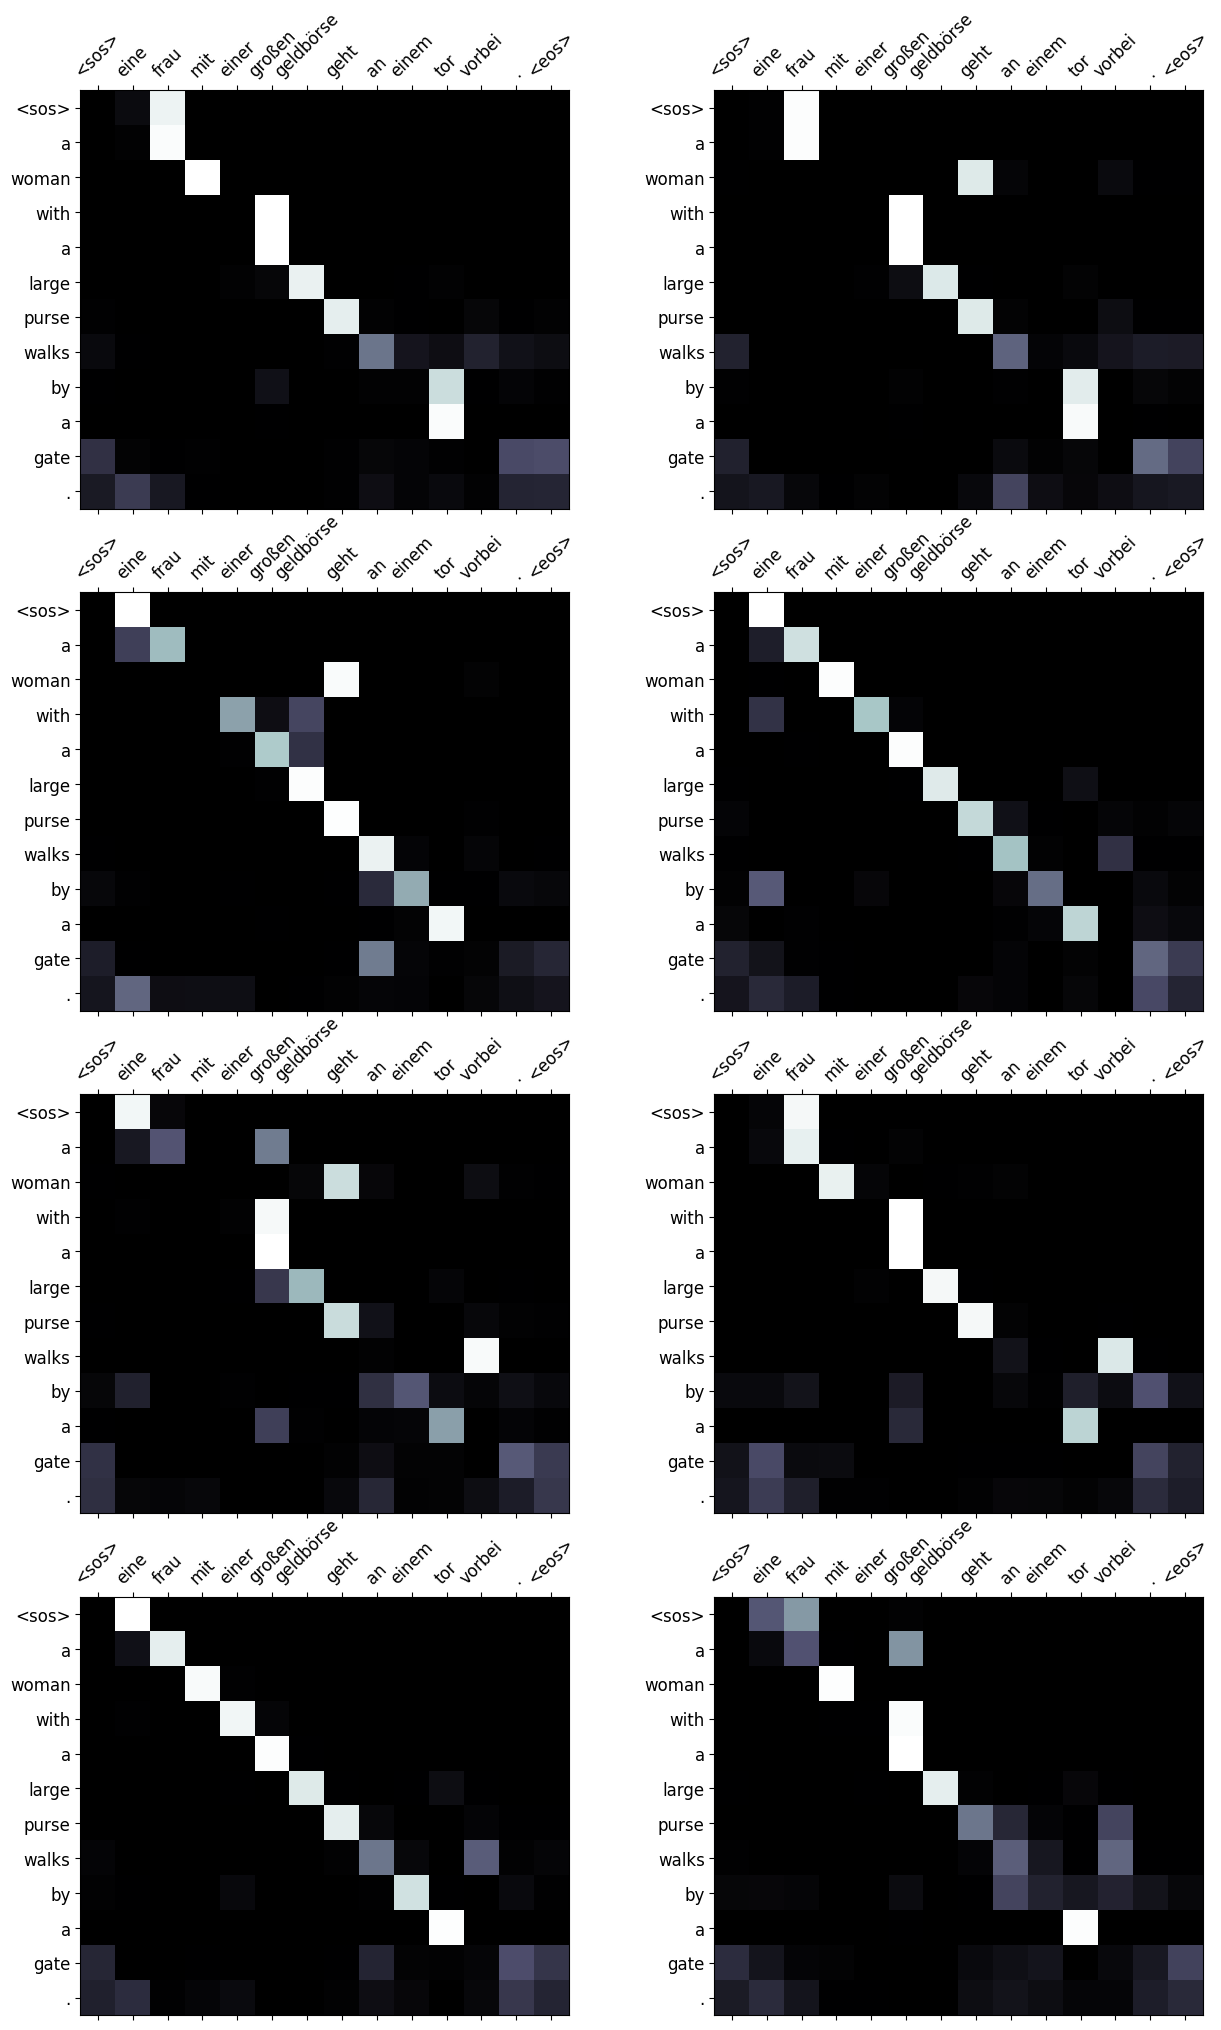

In [74]:
display_attention(sentence, translation, attention)

## 获取验证集中模型未经训练的示例

接下来，让我们从验证集中获取一个模型未经训练的示例。


In [76]:
example_idx = 6

sentence = valid_data[example_idx]["de"]
expected_translation = valid_data[example_idx]["en"]

sentence, expected_translation

('Ein brauner Hund rennt dem schwarzen Hund hinterher.',
 'A brown dog is running after the black dog.')

模型通过将 *is running* 更改为 *running* 来进行翻译，但这是可以接受的替换。

In [78]:
translation, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
)
translation

['<sos>',
 'a',
 'brown',
 'dog',
 'running',
 'after',
 'the',
 'black',
 'dog',
 '.',
 '<eos>']

同样，一些注意头完全关注 "ein"，而其他一些则不关注它。此外，当输出预测的目标句中的句点和 `<eos>` 时，大多数头似乎会在源句中的句点和 `<eos>` 附近的标记上分散注意力，尽管有些头似乎会关注句子开头的标记。


/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


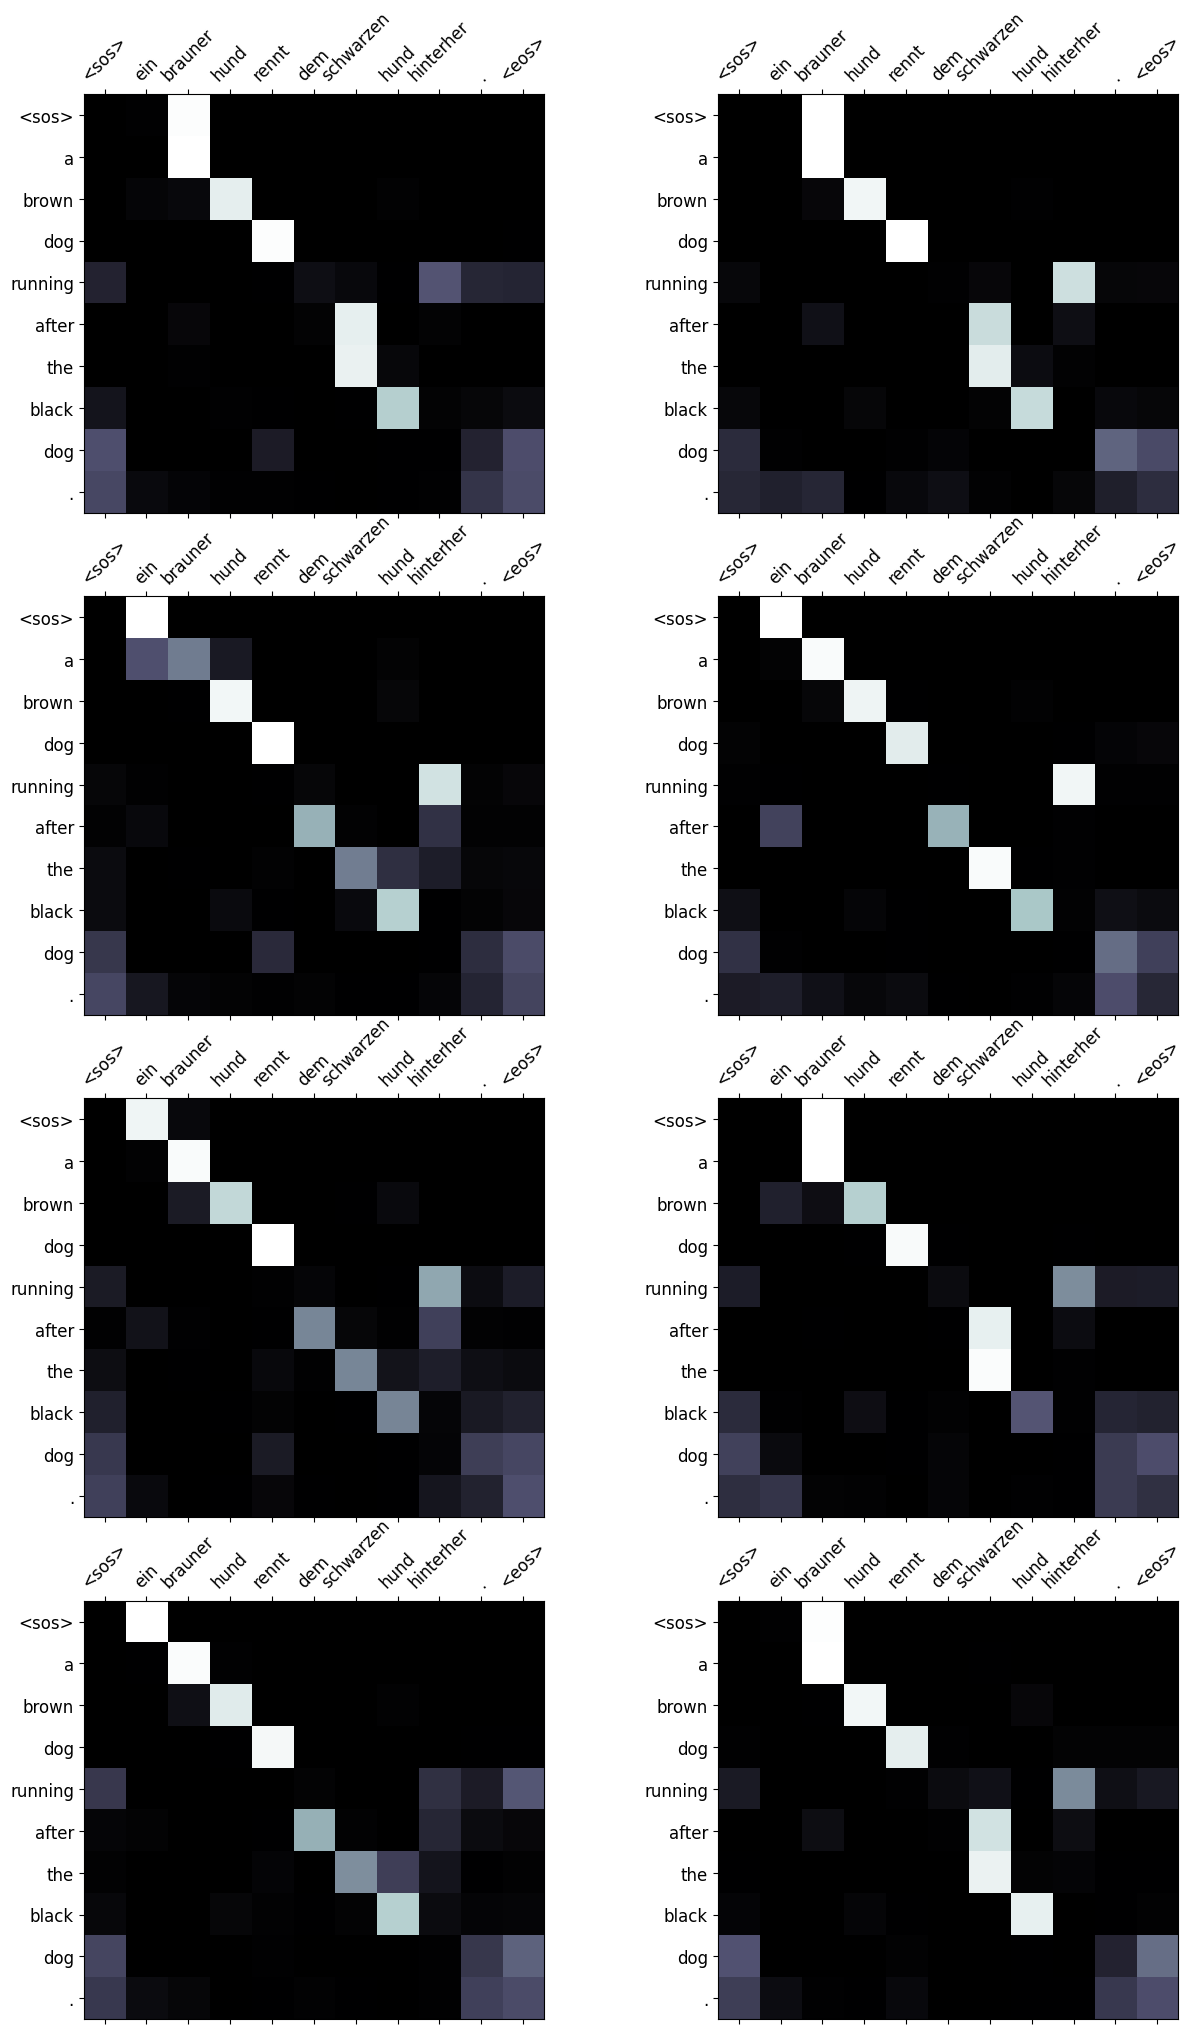

In [79]:
display_attention(sentence, translation, attention)

最后，我们将查看来自测试数据的一个例子。


In [80]:
example_idx = 10

sentence = test_data[example_idx]["de"]
expected_translation = test_data[example_idx]["en"]

sentence, expected_translation

('Eine Mutter und ihr kleiner Sohn genießen einen schönen Tag im Freien.',
 'A mother and her young song enjoying a beautiful day outside.')

翻译得还行（忽视了outside）

In [81]:
translation, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
)
translation

['<sos>',
 'a',
 'mother',
 'and',
 'her',
 'little',
 'son',
 'enjoy',
 'a',
 'beautiful',
 'day',
 '.',
 '<eos>']

/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


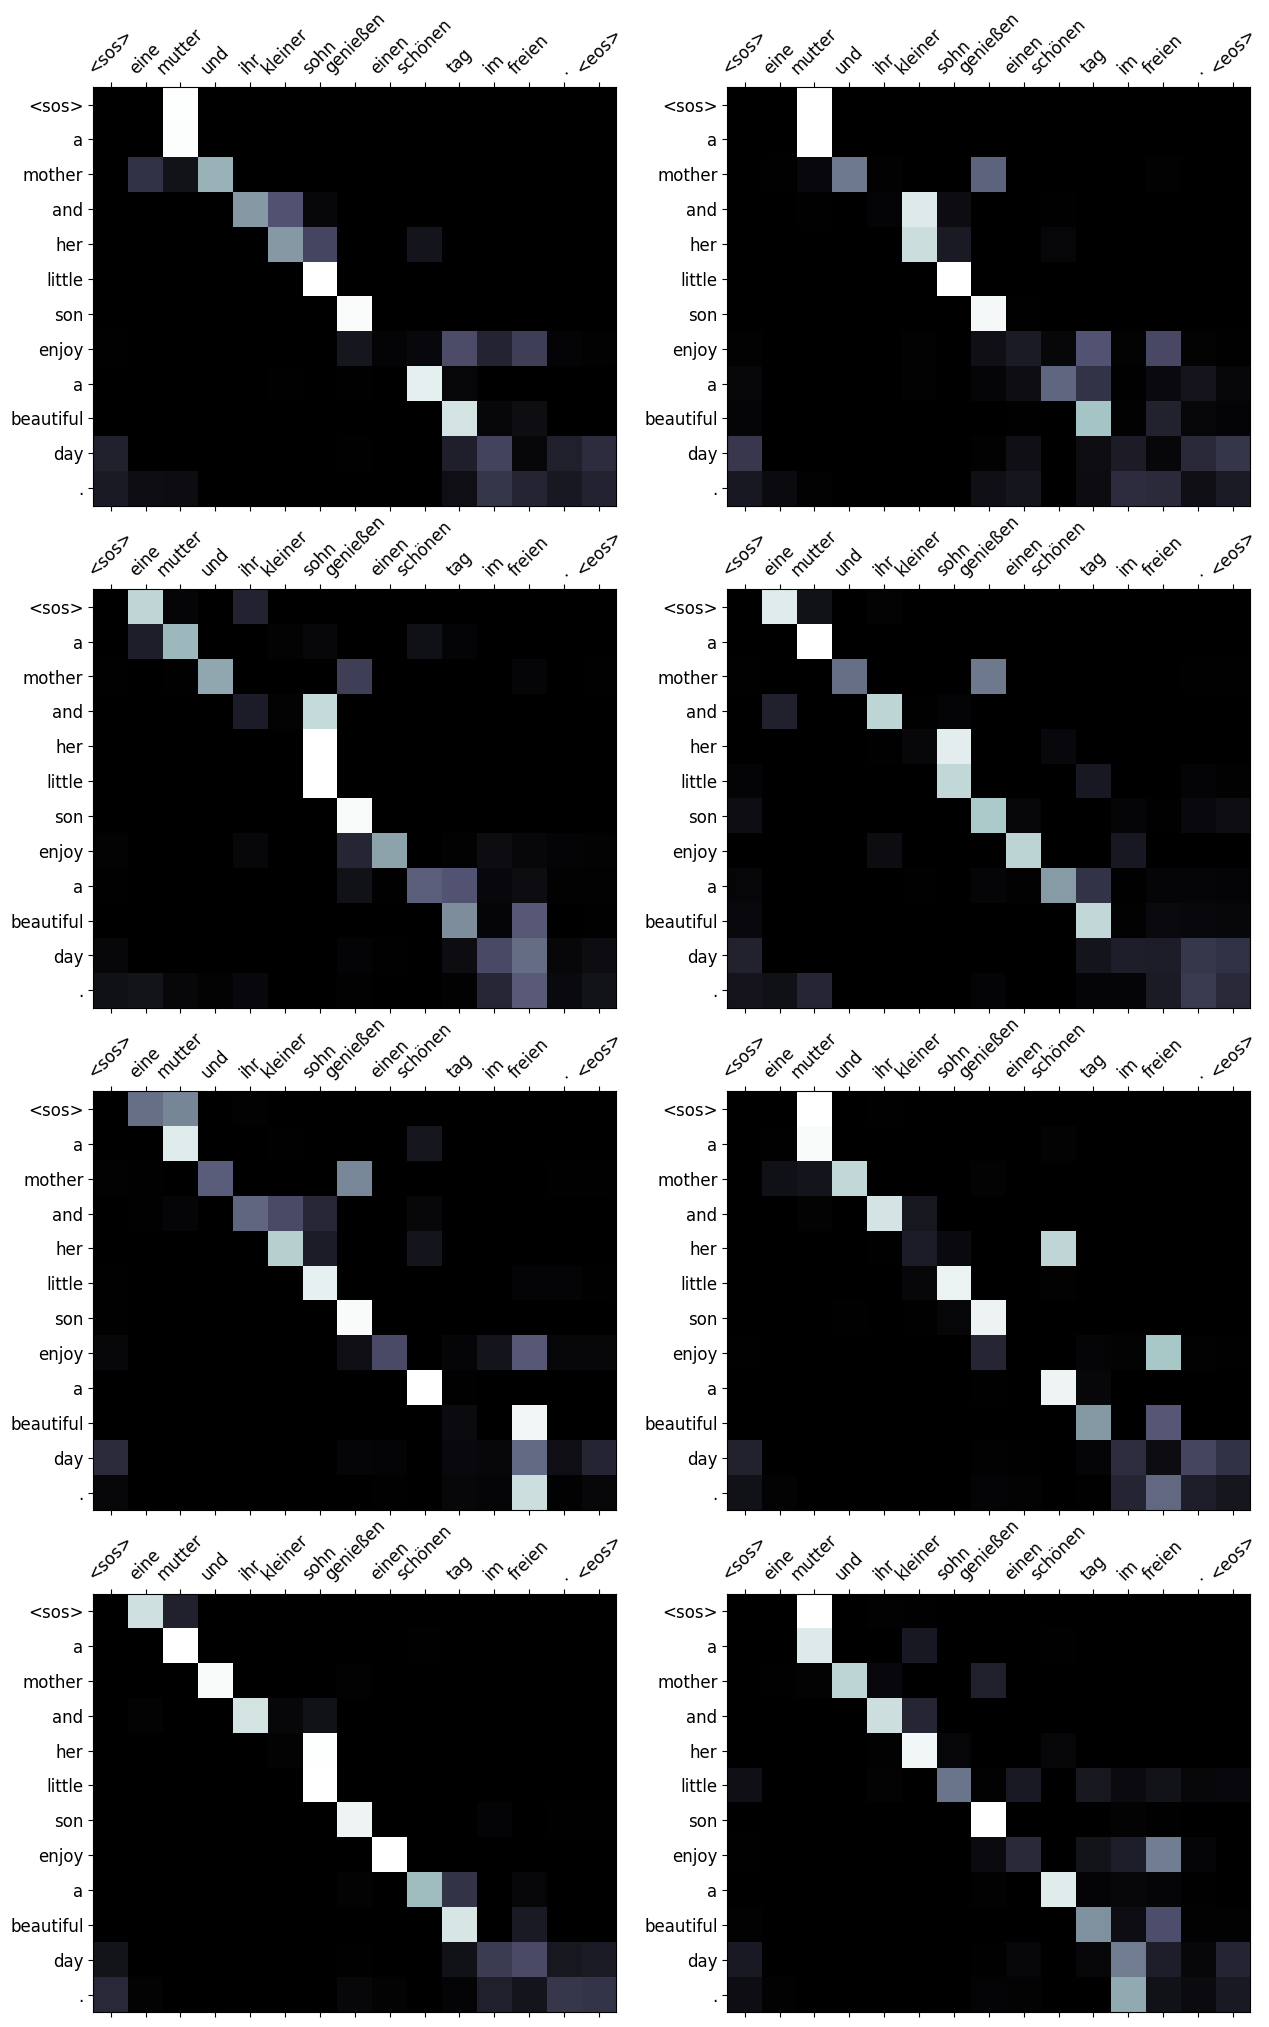

In [82]:
display_attention(sentence, translation, attention)

## BLEU

最后，我们计算Transformer的BLEU分数。


In [83]:
bleu = evaluate_hf.load("bleu")

In [84]:
translations = [
    translate_sentence(
        example["de"],
        model,
        en_nlp,
        de_nlp,
        en_vocab,
        de_vocab,
        lower,
        sos_token,
        eos_token, 
    )[0] for example in tqdm(test_data)
]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [85]:
predictions = [
    " ".join(translation[1:-1]) for translation in translations
]

references = [
    [example["en"]] for example in test_data
]

def get_tokenizer_fn(nlp, lower):
    
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens
        
    return tokenizer_fn

我们得到了一个BLEU分数为0.3239，超过了卷积序列到序列模型和基于注意力的RNN模型。而且这一切都是在参数最少、训练时间最短的情况下实现的！


In [86]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)
results = bleu.compute(predictions=predictions, references=references, tokenizer=tokenizer_fn)
results

{'bleu': 0.32394351941480126,
 'precisions': [0.638349885408709,
  0.3991728701406121,
  0.25545536519386836,
  0.16917740336967294],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0024506049931077,
 'translation_length': 13090,
 'reference_length': 13058}

恭喜你完成这些教程！希望你发现它们很有用。

如果您发现任何错误或对使用的任何代码或解释有任何疑问，请随时提交 GitHub 问题，我将尽快进行更正。
